# Advanced Plotting

by Henry Ngo (2018)

The `results.py` module contains several plotting functions to visualize the results of your `orbitize!` orbit fit. Basic use of these functions are covered in the [OFTI](https://orbitize.readthedocs.io/en/latest/tutorials/OFTI_tutorial.html) and [MCMC](https://orbitize.readthedocs.io/en/latest/tutorials/MCMC_tutorial.html) tutorials. Here, we will examine these plotting functions more deeply. This tutorial will be updated as more features are added to `orbitize!`.

## 1. Test orbit generation with OFTI

In order to have sample data for this tutorial, we will use OFTI to generate some orbits for a published dataset on the GJ 504 system. The following code block is from the [OFTI Tutorial](https://orbitize.readthedocs.io/en/latest/tutorials/OFTI_tutorial.html) , with 10000 orbits generated. Please see that tutorial for details.

**Note: If you have already run this tutorial and saved the computed orbits, you may skip to Section 3 and load up your previously computed orbits instead of running this block below**

In [1]:
import orbitize.driver

myDriver = orbitize.driver.Driver(
    '{}/GJ504.csv'.format(orbitize.DATADIR), # relative or absolute path to data file
    'OFTI', # name of algorithm for orbit-fitting
    1, # number of secondary bodies in system
    1.22, # total system mass [M_sun]
    56.95, # parallax of system [mas]
    mass_err=0.08, # mass error [M_sun]
    plx_err=0.26 # parallax error [mas]
)
s = myDriver.sampler
orbits = s.run_sampler(10000)

## 2. Accessing a Results object with computed orbits

After computing your orbits from either OFTI or MCMC, they are accessible as a `Results` object for further analysis and plotting. This object is an attribute of `s`, the `sampler` object defined above.

In [ ]:
myResults = s.results # array of MxN array of orbital parameters (M orbits with N parameters per orbit)

It is also useful to save this Results object to a file if we want to load up the same data later without re-computing the orbits

In [ ]:
myResults.save_results('plotting_tutorial_GJ504_results.hdf5')

For more information on the Results object, see below.

In [ ]:
myResults?

Note that you can also add more computed orbits to a results object with `myResults.add_samples()`

In [ ]:
myResults.add_samples?

## 3. (Optional) Load up saved results object

If you are skipping the generation of all orbits because you would rather load from a file that saved the Results object generated above, then execute this block to load it up. Otherwise, skip this block (however, nothing bad will happen if you run it even if you generated orbits above).

In [ ]:
import orbitize.results
if 'myResults' in locals():
    del myResults # delete existing Results object 
myResults = orbitize.results.Results() # create empty Results object
myResults.load_results('plotting_tutorial_GJ504_results.hdf5') # load from file

## 4. Using our Results object to make plots

There are currently two plotting functions available: `plot_corner()` makes a corner plot and `plot_orbits()` displays some or all of the computed orbits. Both plotting functions return matplotlib.pyplot.figure objects, which can be displayed, further manipulated with matplotlib.pyplot functions, and saved.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

### 4.1 Corner plots

This function is a wrapper for `corner.py` and creates a display of the 2-D covariances between each pair of parameters as well as histograms for each parameter. These plots are known as "corner plots", "pairs plots", "scatterplot matrix" as well as other names.

In [ ]:
corner_figure = myResults.plot_corner()

#### Choosing which parameters to plot

Sometimes, the full plot with all parameters is not what we want. Let's use the `param_list` keyword argument to plot only semimajor axis, eccentricity and inclination. Here are the possible string labels you can enter for `param_list` and the corresponding orbit fit parameter:

| Label | Parameter name                                                 |
|-------|----------------------------------------------------------------|
| sma1  | semimajor axis                                                 |
| ecc1  | eccentricity                                                   |
| inc1  | inclination                                                    |
| aop1  | argument of periastron                                         |
| pan1  | position angle of nodes <br> (aka longitude of ascending node) |
| epp1  | epoch of periastron passage                                    |
| mtot  | system mass                                                    |
| plx   | system parallax                                                |

Note: for labels with numbers, the number corresponds to the companion (sma1 is the first object's semimajor axis, sma2 would be the second object, etc)

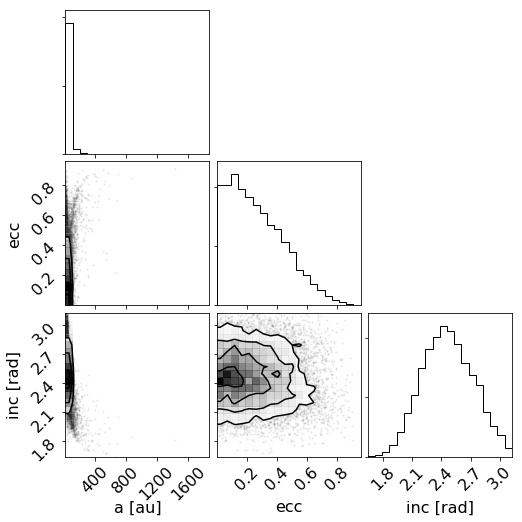

In [23]:
corner_figure_aei = myResults.plot_corner(param_list=['sma1','ecc1','inc1'])

#### Limiting which samples to display

By picking out the panels we show, the plot can be easier to read. But in this case, we see that the plotted x-range on semimajor axis does show the posterior very well. This function will pass on all `corner.corner()` keywords as well. For example, we can use `corner`'s `range` keyword argument to limit the panels to only display 95% of the samples to avoid showing the long tails in the distribution.

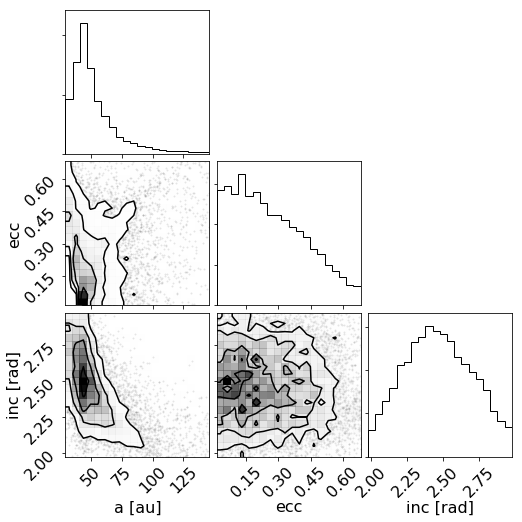

In [24]:
corner_figure_aei_95 = myResults.plot_corner(param_list=['sma1','ecc1','inc1'], range=(0.95,0.95,0.95))

For other keywords you can pass to `corner`, see the `corner.py` [API](https://corner.readthedocs.io/en/latest/api.html "corner.py API").

#### Making single variable histogram plots

One use of the `param_list` keyword is to just plot the histogram for the distribution of one single orbit fit parameter. We can do this by just providing one single parameter.

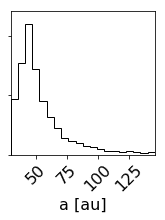

In [25]:
histogram_figure_sma1 = myResults.plot_corner(param_list=['sma1'], range=(0.95,))

#### Axis label customization

The axis labels seen on the above plots are the default labels that `orbitize` passes to `corner.py` to make these plots. We can override these defaults by passing our own labels through the `labels` keyword parameter as per the `corner.py` [API](https://corner.readthedocs.io/en/latest/api.html "corner.py API"). 

Note that the length of the list of `labels` should match the number of parameters plotted.

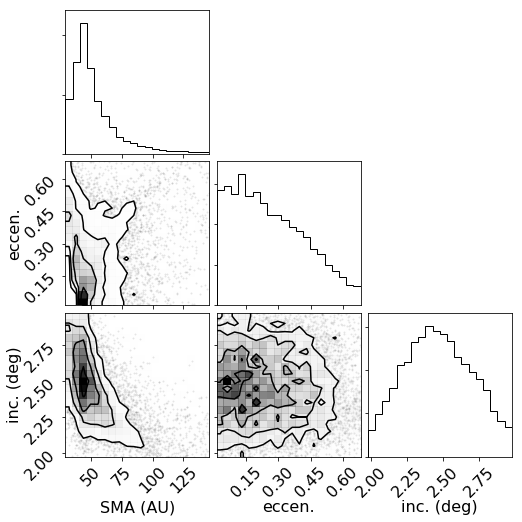

In [26]:
# Corner plot with alternate labels
corner_figure_aei_95_labels = myResults.plot_corner(
    param_list=['sma1','ecc1','inc1'], 
    range=(0.95,0.95,0.95), 
    labels=('SMA (AU)', 'eccen.', 'inc. (deg)')
)

#### Overplotting best fit ("truth") values

One feature of `corner.py` is to overplot the contours and histograms with a so-called "truth" value, which we can use for many purposes. For example, if we are sampling from a known distribution, we can use it to plot the true value to compare with our samples. Or, we can use it to mark the location of the mean or median of the distribution (the histogram and contours make it easy to pick out the most likely value or peaks of the distribution but maybe not the mean or median). Here is an example of overplotting the median on top of the distribution for the full corner plot.

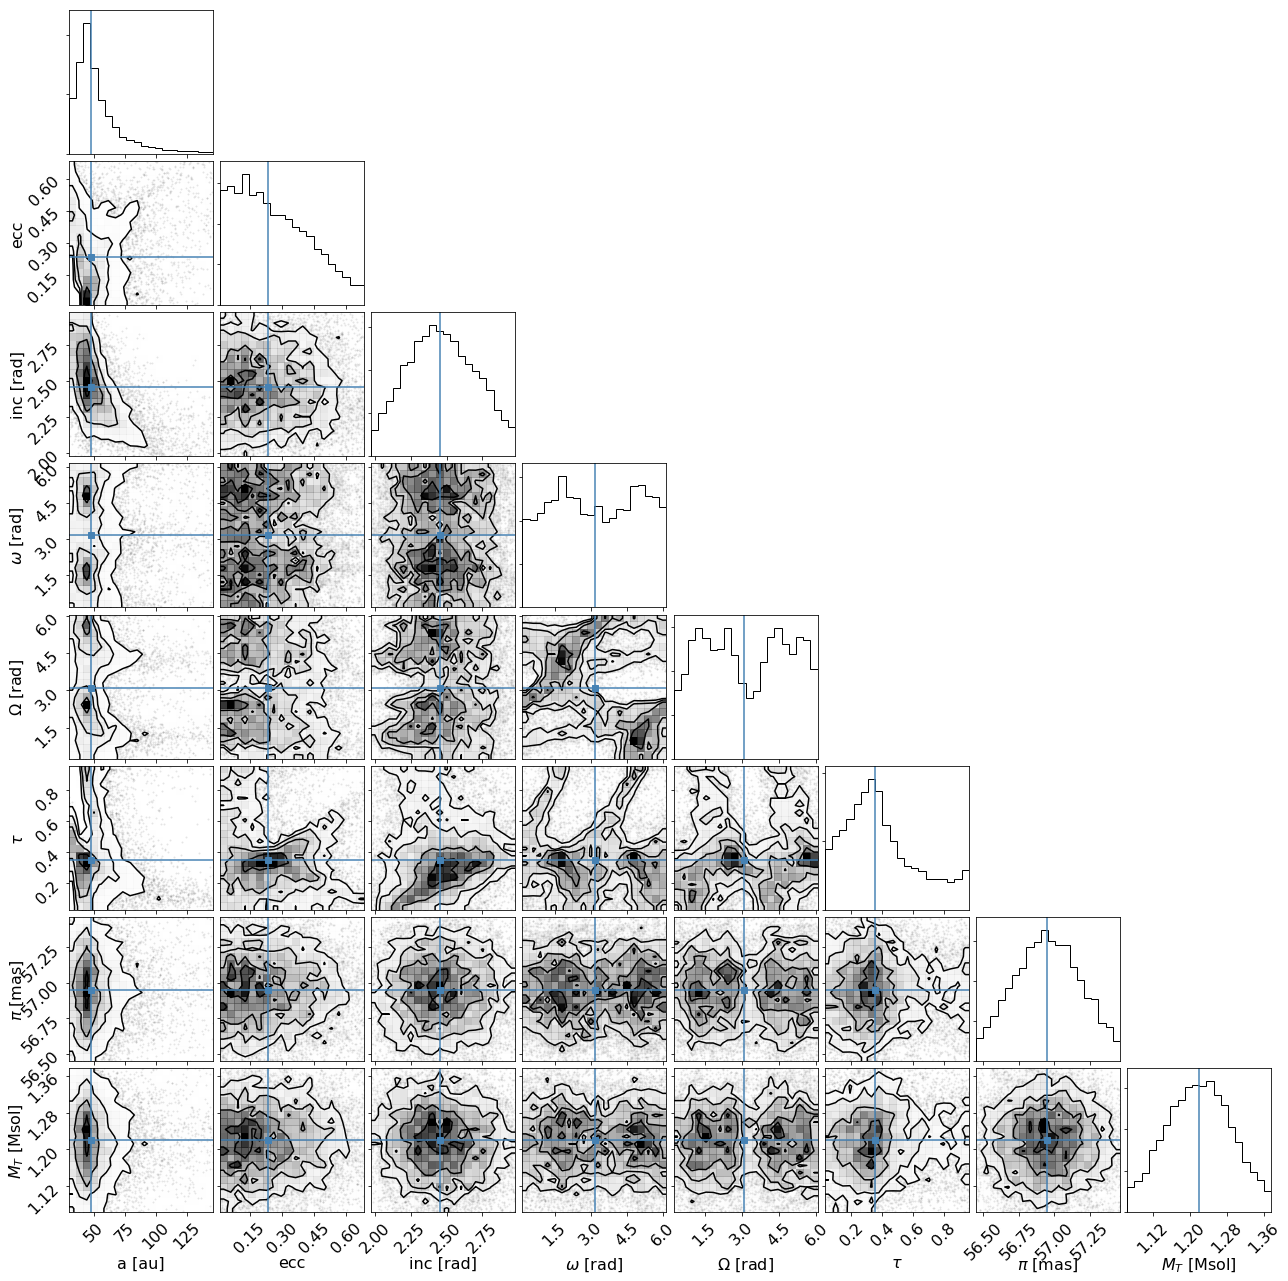

In [27]:
import numpy as np
median_values = np.median(myResults.post,axis=0) # Compute median of each parameter
range_values = np.ones_like(median_values)*0.95 # Plot only 95% range for each parameter
corner_figure_median_95 = myResults.plot_corner(
    range=range_values, 
    truths=median_values
)

Overall, we find that some of the parameters have converged well but others are not well constrained by our fit. As mentioned above, the output of the `plot_corner()` methods are matplotlib Figure objects. So, if we wanted to save this figure, we might use the `savefig()` method.

In [28]:
corner_figure_median_95.savefig('plotting_tutorial_corner_figure_example.png')

### 4.2 Orbit Plot

The `plot_orbits` method in the `Results` module allows us to visualize the orbits sampled by `orbitize!`. The default  call to `plot_orbits` will draw 100 orbits randomly chosen out of the total orbits sampled (set by parameter `num_orbits_to_plot`). In addition, to draw each of these orbits, by default, we will sample each orbit at 100 evenly spaced points in time throughout the orbit's orbital period (set by parameter `num_epochs_to_plot`). These points are then connected by coloured line segments corresponding to the date where the object would be at that point in the orbit. By default, orbits are plotted starting in the year 2000 (set by parameter `start_mjd`) and are drawn for one complete orbital period. We usually choose to begin plotting orbits at the first data epoch, using this keyword as illustrated below.

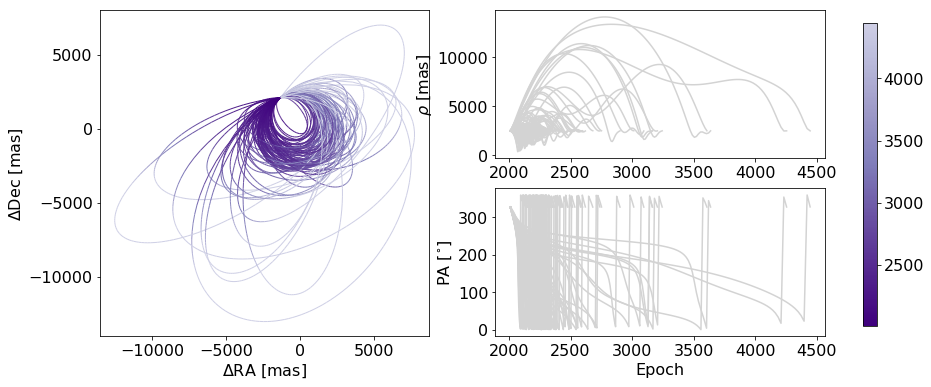

In [29]:
orbit_figure, orbit_axes = myResults.plot_orbits(
    start_mjd=s.epochs[0] # Minimum MJD for colorbar (here we choose first data epoch)
)

#### Customizing orbit plot appearence

In the above figure, we see that the x and y axes are RA and Dec offsets from the primary star in milliarcseconds. By default the axes aspect ratio is square, but we can turn that off. This is normally not recommended but for some situations, it may be desirable. 

(Note: Each call to `plot_orbits` selects a different random subset of orbits to plot, so the orbits shown in the figures here are not exactly the same each time).

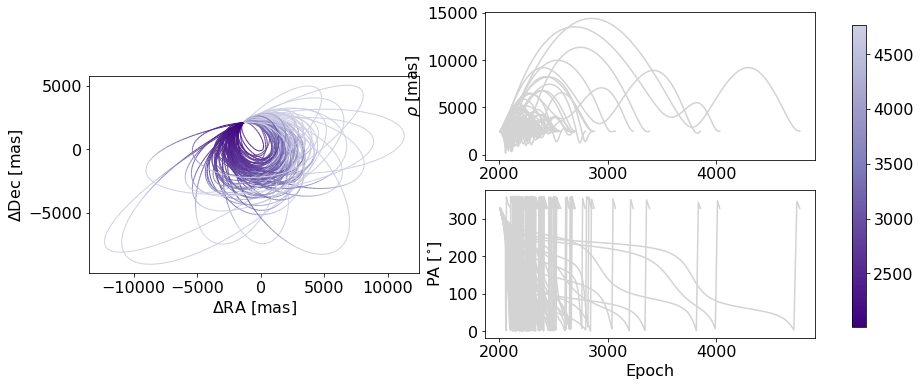

In [30]:
orbit_figure_non_square, non_square_axes = myResults.plot_orbits(
    start_mjd=s.epochs[0],
    square_plot=False
)

The colorbar shows how the line segment colors correspond to the date, beginning at the first data epoch. We can also turn off the colourbar.

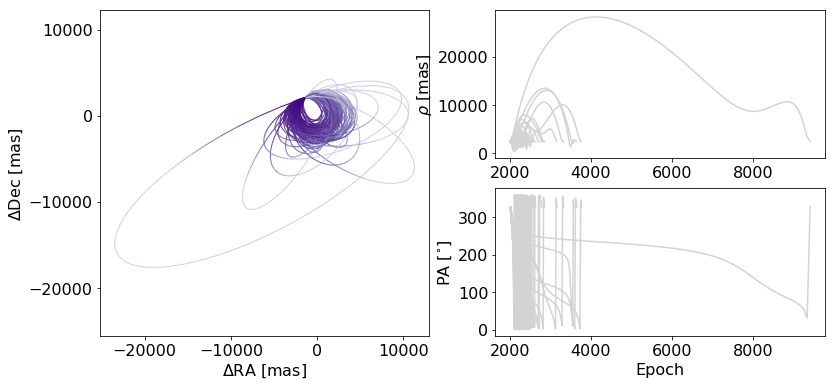

In [31]:
orbit_figure_no_colorbar = myResults.plot_orbits(
    start_mjd=s.epochs[0],
    show_colorbar=False
)

#### Choosing how orbits are plotted

Plotting one hundred orbits may be too dense. We can set the number of orbits displayed to any other value.

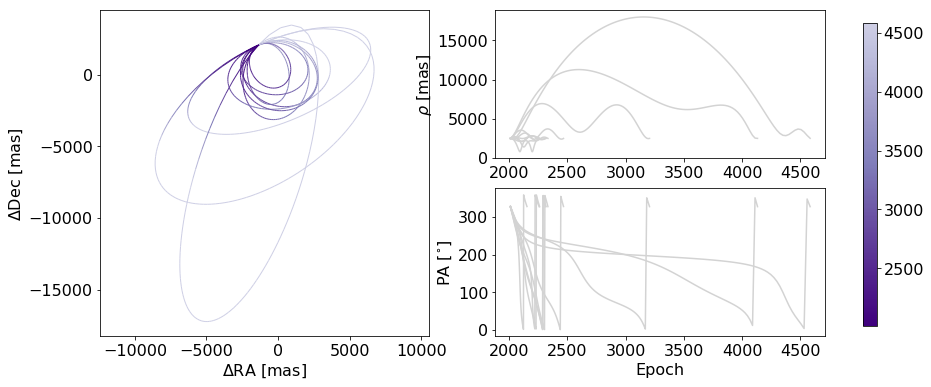

In [32]:
orbit_figure_plot10 = myResults.plot_orbits(
    start_mjd=s.epochs[0],
    num_orbits_to_plot=10
)

We can also adjust how well we sample each of the orbits. By default, 100 evenly-spaced points are computed per orbit, beginning at `start_mjd` and ending one orbital period later. Decreasing the sampling could lead to faster plot generation but if it is too low, it might not correctly sample the orbit, as shown below.

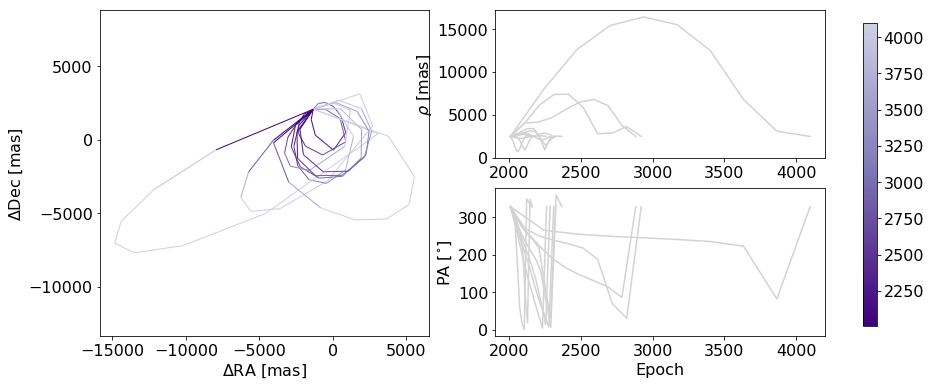

In [33]:
orbit_figure_epochs10 = myResults.plot_orbits(
    start_mjd=s.epochs[0],
    num_epochs_to_plot=10, 
    num_orbits_to_plot=10
)

In this example, there is only one companion in orbit around the primary. When there are more than one, `plot_orbits` will plot the orbits of the first companion by default and we would use the `object_to_plot` argument to choose a different object (where `1` is the first companion).

#### Fixed parameters (object mass, parallax, total mass)

Orbits are plotted for a test particle, but the mass of the object in orbit can be provided, in solar masses, with the `object_mass` argument. However, this value is only used to compute radial velocities, which are not currently plotted with `plot_orbits`. Therefore, this argument has no effect at this time, but is included for future compatibility.

In this example, we are fitting for system parallax and total system mass with OFTI, and therefore the posteriors on these two parameters are already included in the `Results` object and are part of each orbit's fit. However, in cases where we are using fixed values for system parallax and total system mass, `plot_orbits` must know these fixed values in order to compute the orbits, so they must be provided. We would provide the parallax, in millarcseconds, as the `parallax` argument and the system mass, in solar masses, as the `total_mass` argument. Both values should be floats.

`plot_orbits` will automatically detect whether the orbit fit results has posteriors on parallax and total mass. If they exist, then `plot_orbits` will use these results and ignore whatever we input with the `parallax` and `total_mass` arguments.


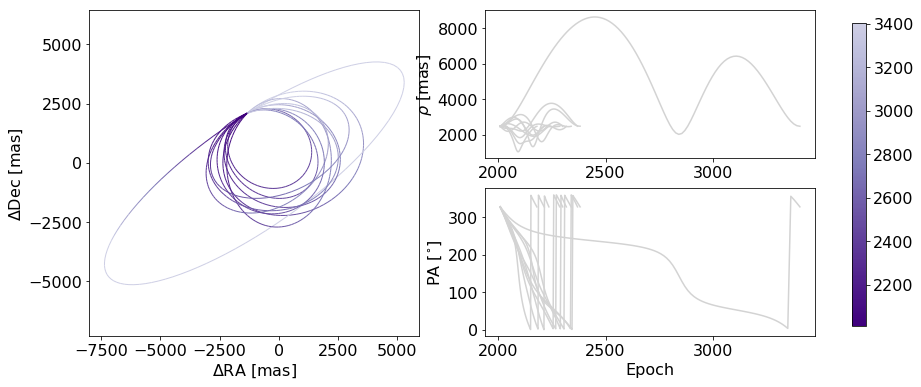

In [35]:
orbit_figure_plot10_ignored_example = myResults.plot_orbits(
    start_mjd=s.epochs[0],
    num_orbits_to_plot=10, 
    parallax=50, # this input is ignored because the fit results already has a posterior for parallax
    total_mass=1.0 # this input is ignored because the fit results already has a posterior for total mass
)

### 4.3 Working with `matplotlib` Figure objects

The idea of the `Results` plotting functions is to create some basic plots and to return the `matplotlib` Figure object so that we can do whatever else we may want to customize the figure. We should consult the `matplotlib` [API](https://matplotlib.org/api/index.html "matplotlib API") for all the details. Here, we will outline a few common tasks.

Let's increase the font sizes for all of the text (maybe for a poster or oral presentation) using `matplotlib.pyplot`. This (and other edits to the `rcParams` defaults) should be done before creating any figure objects.

In [36]:
plt.rcParams.update({'font.size': 16})

Now, we will start with creating a figure with only 5 orbits plotted, for simplicity, with the name `orb_fig`. This `Figure` object has two axes, one for the orbit plot and one for the colorbar. We can use the `.axes` property to get a list of axes. Here, we've named the two axes `ax_orb` and `ax_cbar`. With these three objects (`orb_fig` and `ax_orb`, and `ax_cbar`) we can modify all aspects of our figure.

AttributeError: 'tuple' object has no attribute 'axes'

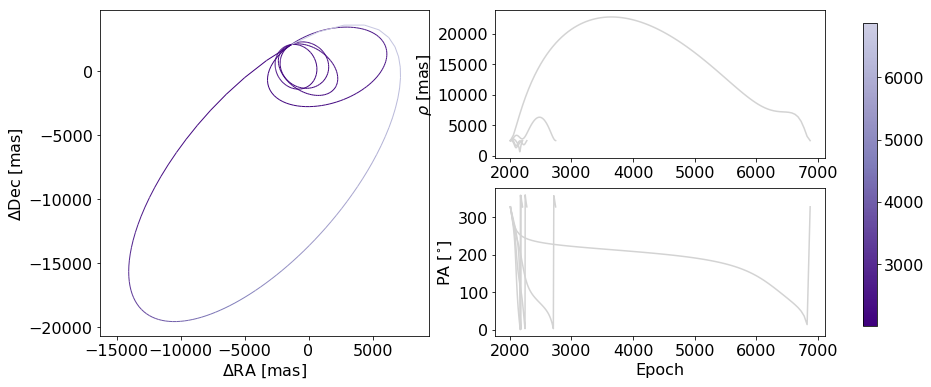

In [38]:
orb_fig = myResults.plot_orbits(start_mjd=s.epochs[0], num_orbits_to_plot=5)
ax_orb, ax_cbar = orb_fig.axes

First, let's try to add a figure title. We have two options. We can use the Figure's `suptitle` method to add a title that spans the entire figure (including the colorbar).

In [ ]:
orb_fig.suptitle('5 orbits from GJ-504 fits') # Adds a title spanning the figure
orb_fig

Alternatively, we can just add the title over the axes instead.

In [ ]:
orb_fig.suptitle('') # Clears previous title
ax_orb.set_title('5 orbits from GJ-504 fits') # sets title over Axes object only
orb_fig

We can also change the label of the axes, now using `matplotlib.Axes` methods.

In [ ]:
ax_orb.set_xlabel('$\Delta$(Right Ascension, mas)')
ax_orb.set_ylabel('$\Delta$(Declination, mas)')
orb_fig

If we want to modify the colorbar axis, we need to access the `ax_cbar` object

In [ ]:
ax_orb.set_xlabel('$\Delta$RA [mas]')
ax_orb.set_ylabel('$\Delta$Dec [mas]') # go back to what we had before
ax_cbar.set_title('Year') # Put a title on the colorbar
orb_fig

We may want to add to the plot itself. Here's an exmaple of putting an star-shaped point at the location of our primary star.

In [ ]:
ax_orb.plot(0,0,marker="*",color='black',markersize=10)
orb_fig

And finally, we can save the figure objects.

In [ ]:
orb_fig.tight_layout() # Ensures axis labels fit onto image
orb_fig.savefig('plotting_tutorial_plot_orbit_example.png')